# Initialize the program

This code demonstrates the use of PyTorch and Captum to perform attribution analysis on an image using a pre-trained ResNet18 model. The purpose is to understand which parts of the image contribute most to the model's predictions for specific objects, such as different breeds of dogs and cats.

Initialization:

    Imports necessary libraries, including PyTorch, Captum, and PIL.
    Loads a pre-trained ResNet18 model.
    Defines an image processing pipeline using torchvision transforms.
    Opens an image (in this case, "data/both.png").

<div class="alert alert-block alert-info">
The process involves loading an image, preprocessing it through transformations (such as resizing and normalization).
</div>

In [1]:
import torchvision
from torchvision import models, transforms
from PIL import Image
import requests
from io import BytesIO
import torch
import torch.nn.functional as F

model = torchvision.models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).eval()

img = Image.open("data/both.png") # photo of a tabby cat and bulldog

center_crop = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
])

normalize = transforms.Compose([
    transforms.ToTensor(),               # converts the image to a tensor with values between 0 and 1
    transforms.Normalize(                # normalize to follow 0-centered imagenet pixel RGB distribution
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
    )
])
input_img = normalize(center_crop(img)).unsqueeze(0)

Model Prediction (Optional):

    Performs predictions using the pre-trained model on the input image.
    Displays the top five predictions with their confidence scores (if enabled).
<div class="alert alert-block alert-info">
The code uses a ResNet18 model, trained on ImageNet, to identify objects in an input image. It processes the image, feeds it to the model, and gets the output probabilities. <br> Then, it finds the top 5 predictions, retrieving their labels and optionally displaying the confidence level for each. This shows the model's ability to identify objects and rank its predictions.
</div>

In [15]:
Do_Predictions = True  # Set this to True to enable predictions

if Do_Predictions:
    # Get model prediction
    with torch.no_grad():
        outputs = model(input_img)

    # Get ImageNet labels
    LABELS_URL = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
    labels = requests.get(LABELS_URL).json()

    # Calculate probabilities
    probabilities = F.softmax(outputs, dim=1)
    top5_probabilities, top5_classes = torch.topk(probabilities, 5)

    # Display top 5 predictions
    print("Top 5 Predictions:")
    for i in range(5):
        label_index = top5_classes[0][i].item()
        confidence = top5_probabilities[0][i].item() * 100
        predicted_label = labels[label_index]
        print(f"{i + 1}. {predicted_label}: {confidence:.2f}%")
    top1k_probabilities, top1k_classes = torch.topk(probabilities, 1000)




Top 5 Predictions:
1. Boxer: 41.62%
2. Bullmastiff: 20.92%
3. tiger cat: 17.25%
4. tiger: 17.22%
5. American Staffordshire Terrier: 1.53%

73. Labrador Retriever: 0.00%


Image Preprocessing:

    Applies a center crop to the image.
    Normalizes the image according to the mean and standard deviation of the ImageNet dataset.

<div class="alert alert-block alert-info">
The Captum library's Occlusion method is applied to analyze the model's behavior.<br> 
Occlusion is used to occlude parts of the image systematically and observe how it affects the model's predictions for different target objects.
</div>

In [16]:
from captum.attr import Occlusion

attribution_dog = {}
attribution_cat = {}
target_dict = {"Boxer": 242, "Labrador": 208,"French Bulldog": 245, "Persian": 283,"Tabby": 281, "Hammerhead": 4}
def get_target_occlusion(target, input_img):

    occlusion = Occlusion(model)

    strides = (3, 9, 9)               # smaller = more fine-grained attribution but slower
    
    sliding_window_shapes=(3,45, 45)  # choose size enough to change object appearance
    baselines = 0                     # values to occlude the image with. 0 corresponds to gray
    return occlusion.attribute(input_img,
                                       strides = strides,
                                       target=target,
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=baselines)

target=242,                       # Boxer index in ImageNet
attribution_dog["Boxer"] = get_target_occlusion(target, input_img)

target=208,                       # Labrador index in ImageNet
attribution_dog["Labrador"] = get_target_occlusion(target, input_img)

target=245,                       # French Bulldog index in ImageNet
attribution_dog["French Bulldog"] = get_target_occlusion(target, input_img)

target=283,                       # Persian cat index in ImageNet
attribution_cat["Persian"] = get_target_occlusion(target, input_img)

target=281,                       # Tabby cat index in ImageNet
attribution_cat["Tabby"] = get_target_occlusion(target, input_img)

target=4,                       # Hammerhead index in ImageNet
attribution_cat["Hammerhead"] = get_target_occlusion(target, input_img)

Visualization:

    Utilizes Captum's visualization module to create heat maps showing the attribution of importance for each target class.
    Saves the visualizations as PNG images in the "data" folder.
    
<div class="alert alert-block alert-info">
The code iterates through various target classes within ImageNet (Boxer, Labrador, French Bulldog for dogs, Persian, Tabby, Hammerhead for cats) and generates attributions.<br> 
These represent the significance of different image regions for each target class and the attributions are visualized as heat maps overlaid on the original image using Captum's visualization functions.
</div>

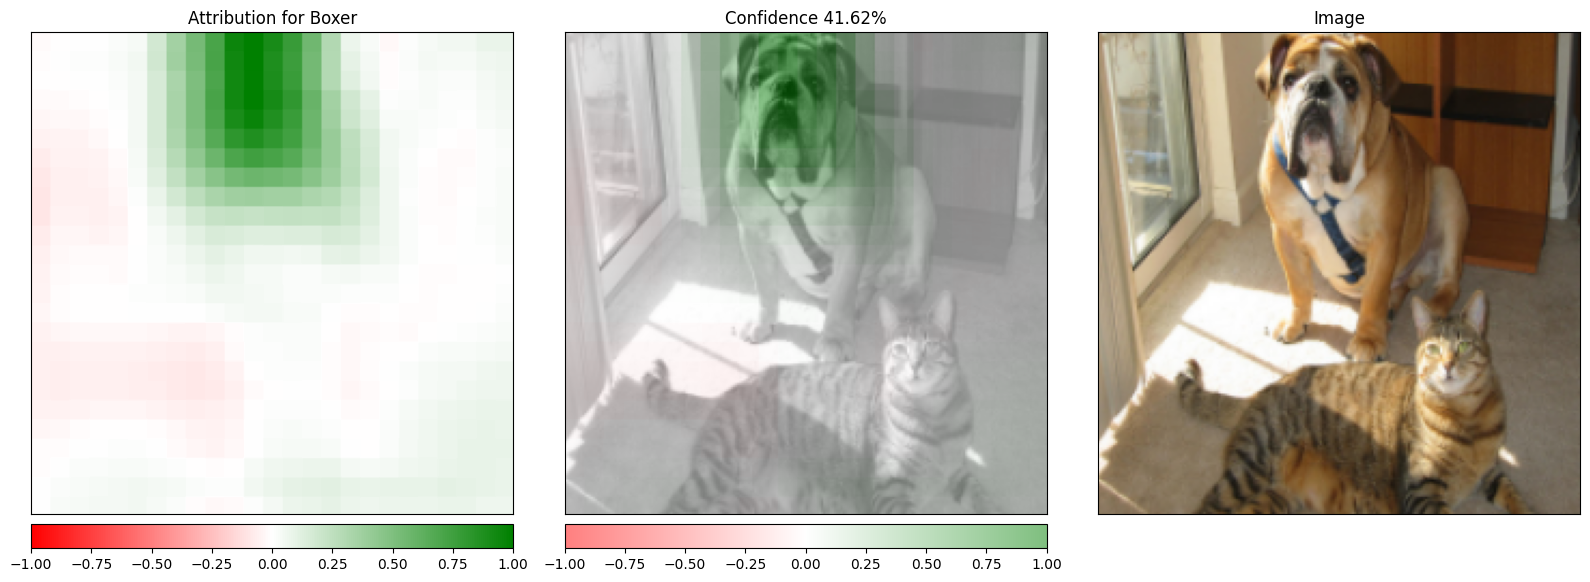

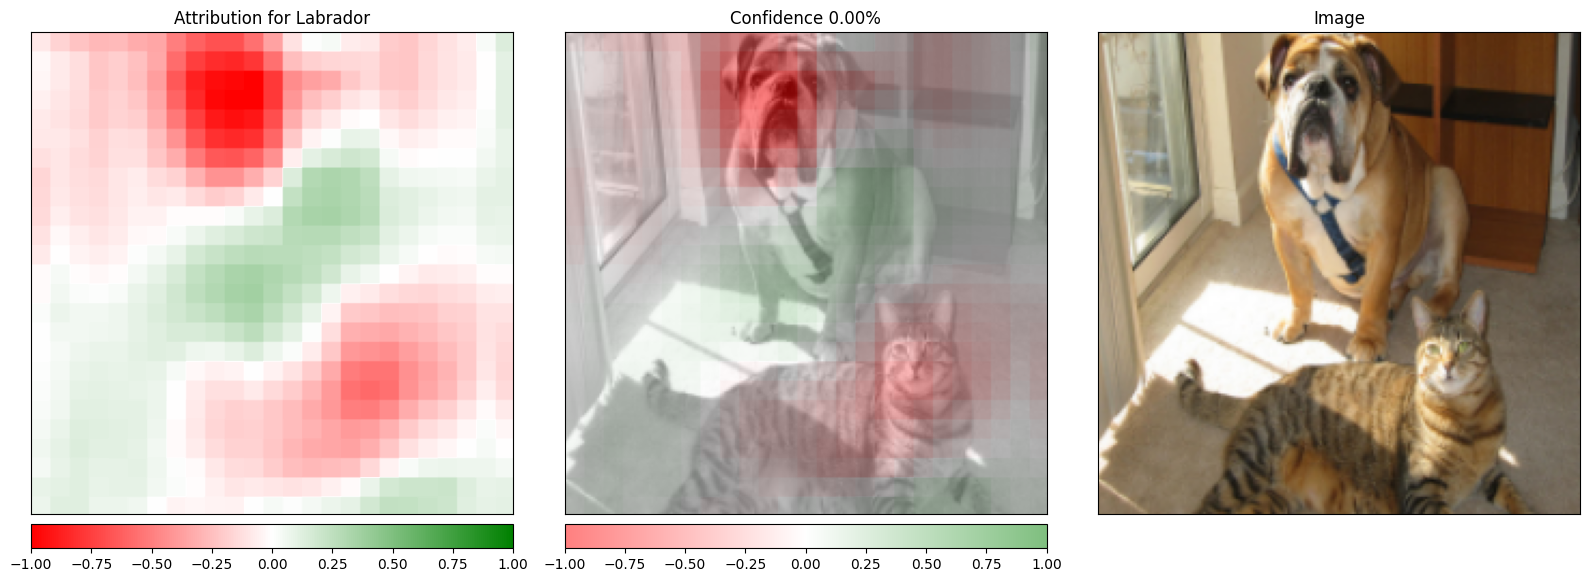

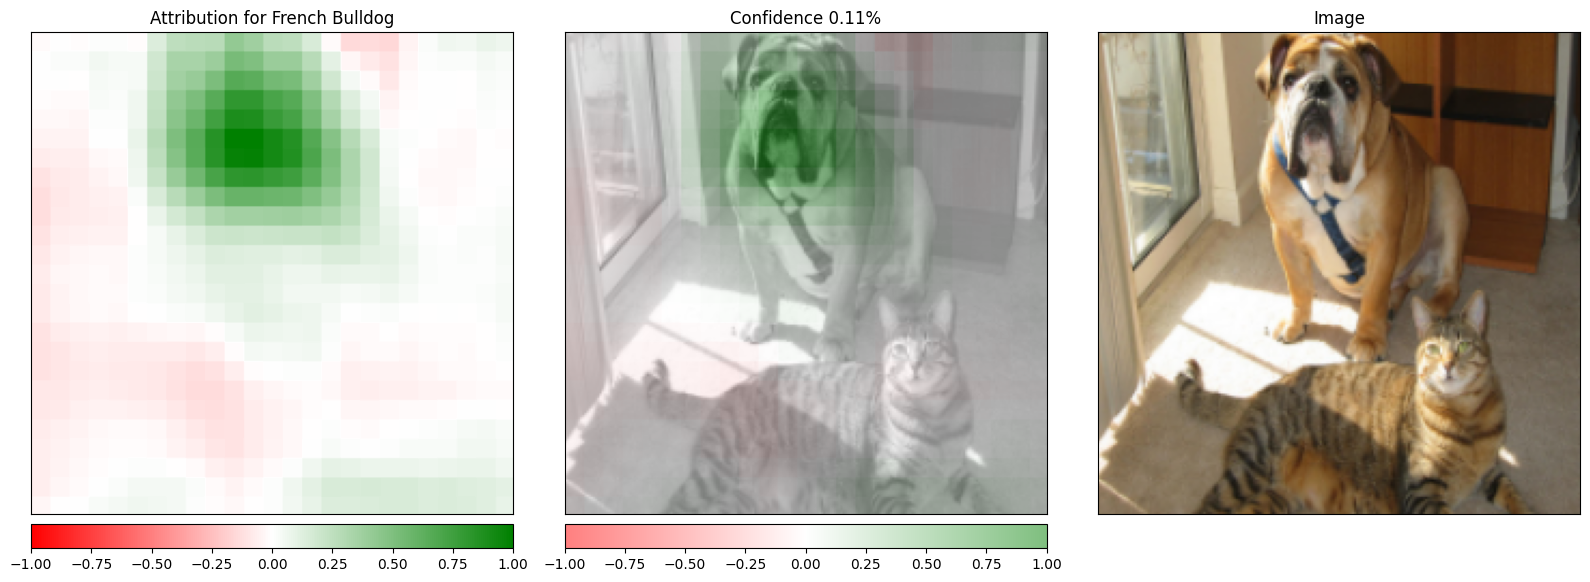

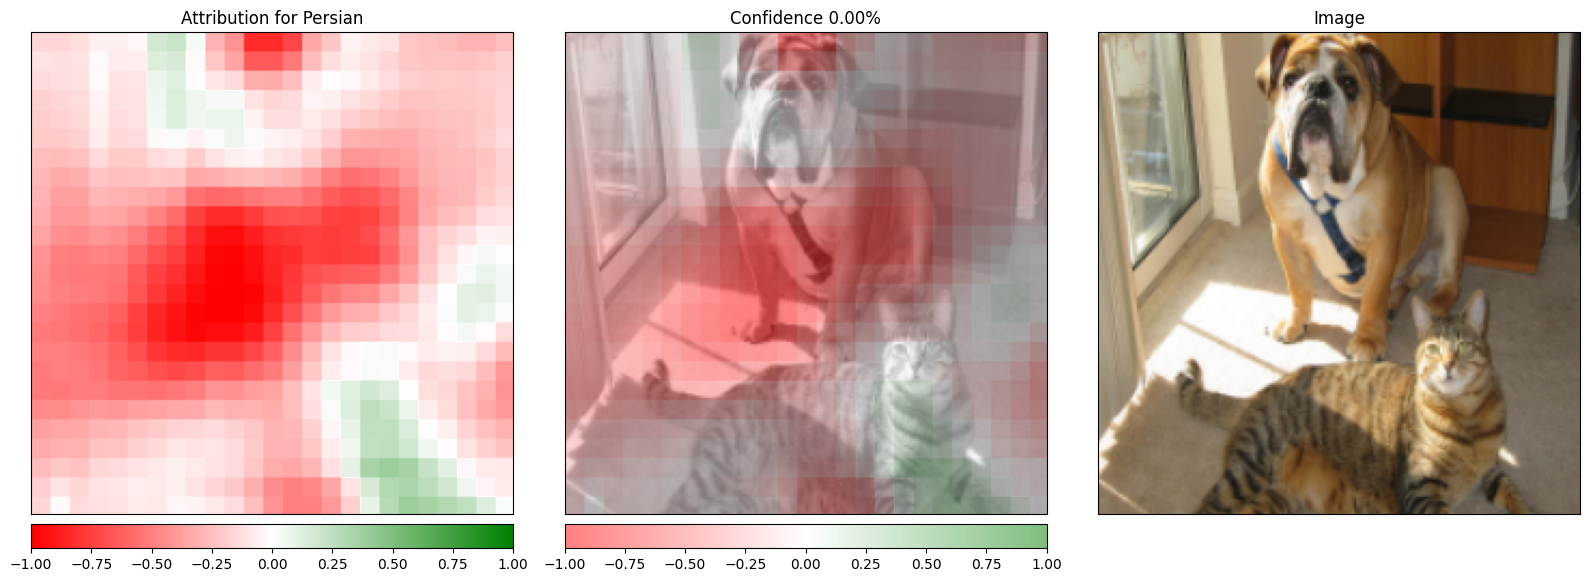

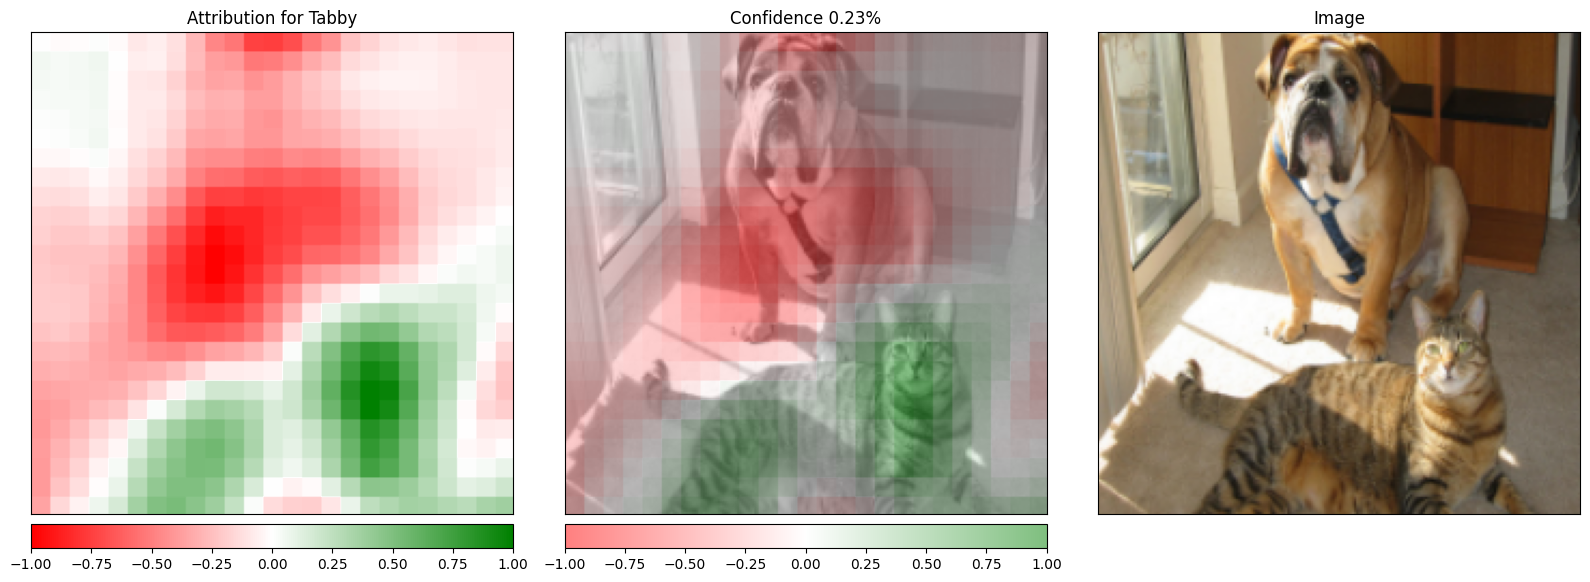

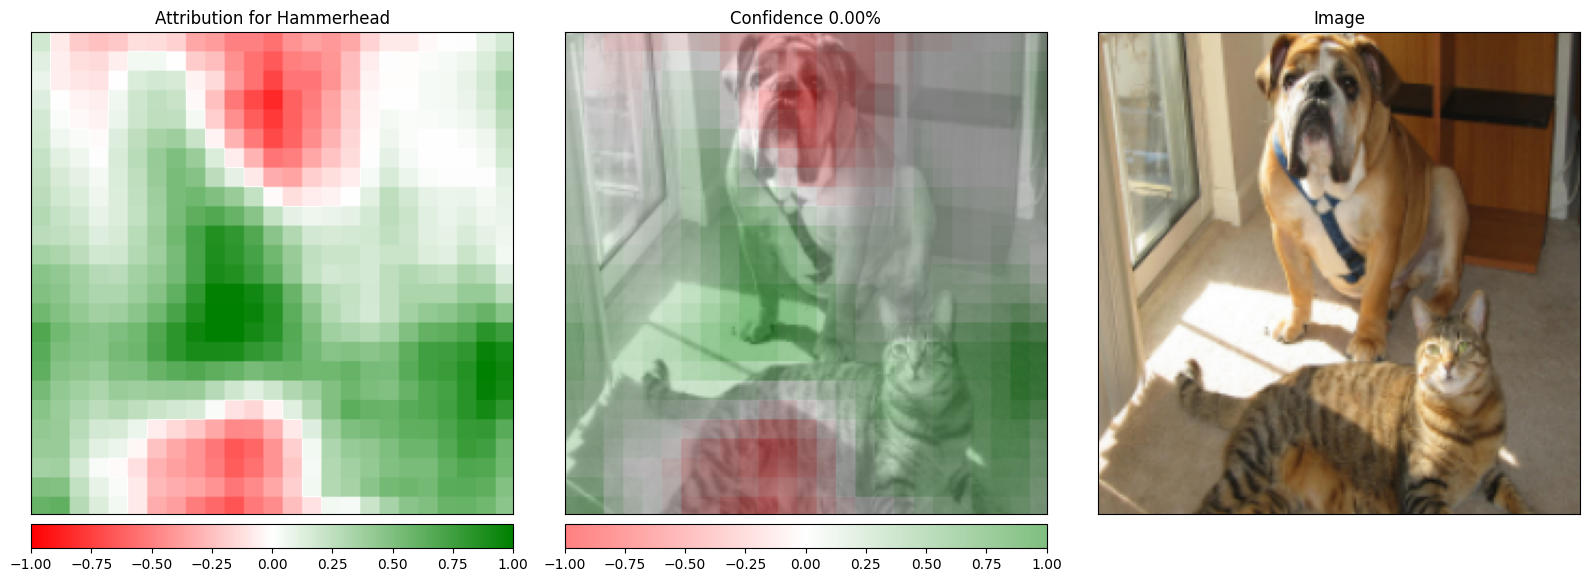

In [25]:
import numpy as np
from captum.attr import visualization as viz


def confidence_score_of_image(target_index):        
    for i in range(len(labels)):
        label_index = top1k_classes[0][i].item()        
        if label_index == target_index:
            confidence = top1k_probabilities[0][i].item() * 100
            return confidence


def show_attributions(value_attribution, label):

    # Convert the compute attribution tensor into an image-like numpy array
    value_attribution = np.transpose(value_attribution.squeeze().cpu().detach().numpy(), (1,2,0))

    vis_types = ["heat_map","blended_heat_map", "original_image"]
    vis_signs = ["all","all", "all"] # "positive", "negative", or "all" to show both
    # positive attribution indicates that the presence of the area increases the prediction score
    # negative attribution indicates distractor areas whose absence increases the score

    vis_plt = viz.visualize_image_attr_multiple(value_attribution,
                                        np.array(center_crop(img)),
                                        vis_types,
                                        vis_signs,
                                        [f"Attribution for {label}", f"Confidence {confidence_score_of_image(target_dict[label]):.2f}%", "Image"],
                                        show_colorbar = True,
                                        use_pyplot=True,
                                        fig_size=(16,16)                                        
                                     )
    vis_plt[0].savefig(f"data/{label}.png")

for key, value in attribution_dog.items():
    show_attributions(value, key)
for key, value in attribution_cat.items():
    show_attributions(value, key)
